In [1]:
import os
import io
import csv
from pathlib import Path
from base64 import b64encode
import fitz  # PyMuPDF

# Load the ID-to-Title mapping CSV: expects columns "id" and "title"
id_title_path = os.path.join("IRPapers", "ID-to-Title.csv")
id_to_title = {}
with open(id_title_path, mode="r", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Assuming pdf name is like '1.PDF', we take the ID as the filename (minus extension)
        id_ = str(row["ID"]).strip()
        title = row["Title"].strip()
        id_to_title[id_] = title

def extract_pdf_pages_base64(pdf_file, dpi, fmt):
    """Extracts each page of the PDF as a dict with base64 representation and metadata."""
    pdf_name = os.path.basename(pdf_file)
    pdf_id, _ = os.path.splitext(pdf_name)
    pdf_title = id_to_title.get(pdf_id, "")
    zoom = dpi / 72.0
    mat = fitz.Matrix(zoom, zoom)
    try:
        doc = fitz.open(pdf_file)
    except Exception as e:
        # Optionally, could log or yield an error object here
        return []
    pages_result = []
    for i, page in enumerate(doc, start=1):
        pix = page.get_pixmap(matrix=mat, alpha=False)
        buf = io.BytesIO()
        img_bytes = pix.pil_tobytes(format=fmt.upper())
        buf.write(img_bytes)
        byte_data = buf.getvalue()
        base64_str = b64encode(byte_data).decode("utf-8")
        base64_bytes = len(base64_str.encode("utf-8"))
        
        # Create unique dataset_id using string composite
        dataset_id = f"{pdf_id}_{i}"
        
        pages_result.append({
            "dataset_id": dataset_id,
            "pdf_id": pdf_id,
            "pdf_name": pdf_name,
            "pdf_title": pdf_title,
            "page_number": i,
            "base64_str": base64_str,
            "base64_bytes": base64_bytes
        })
    doc.close()
    print(f"✓ Processed {len(pages_result)} pages from {pdf_name} ({pdf_title})")
    return pages_result

def find_all_pdfs(folder_path):
    pdf_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(".pdf"):
                pdf_files.append(os.path.join(root, file))
    return pdf_files

# Example usage for "IRPapers" folder
root_folder = "IRPapers"
pdf_paths = find_all_pdfs(root_folder)

# Parameters: DPI and format (e.g., 150, "png" or "jpeg")
dpi = 300
fmt = "png"

# Process all PDFs and collect results in a flat list (one entry per page)
all_results = []
for pdf_path in pdf_paths:
    page_entries = extract_pdf_pages_base64(pdf_path, dpi, fmt)
    all_results.extend(page_entries)

# "all_results" now contains dicts of schema:
# dataset_id: str
# pdf_id: str
# pdf_name: str
# pdf_title: str
# page_number: int
# base64_str: str
# base64_bytes: int

✓ Processed 20 pages from 98.pdf (Internet-augmented language models through few-shot prompting for open-domain question answering)
✓ Processed 25 pages from 99.pdf (Measuring and Narrowing the Compositionality Gap in Language Models)
✓ Processed 15 pages from 103.pdf (In-Context Retrieval-Augmented Language Models)
✓ Processed 12 pages from 117.pdf (Learning to Filter Context for Retrieval-Augmented Generation)
✓ Processed 30 pages from 116.pdf (Self-RAG: Learning to Retrieve, Generate, and Critique Through Self-Reflection)
✓ Processed 12 pages from 102.pdf (REPLUG: Retrieval-Augmented Black-Box Language Models)
✓ Processed 23 pages from 114.pdf (RECOMP: Improving Retrieval-Augmented LMs with Compression and Selective Augmentation)
✓ Processed 15 pages from 100.pdf (Demonstrate-Search-Predict: Composing retrieval and language models for knowledge-intensive NLP)
✓ Processed 15 pages from 101.pdf (Rethinking with Retrieval: Faithful Large Language Model Inference)
✓ Processed 5 pages fr

In [2]:
all_results[0].keys()

dict_keys(['dataset_id', 'pdf_id', 'pdf_name', 'pdf_title', 'page_number', 'base64_str', 'base64_bytes'])

In [3]:
all_results[0]["dataset_id"]

'98_1'

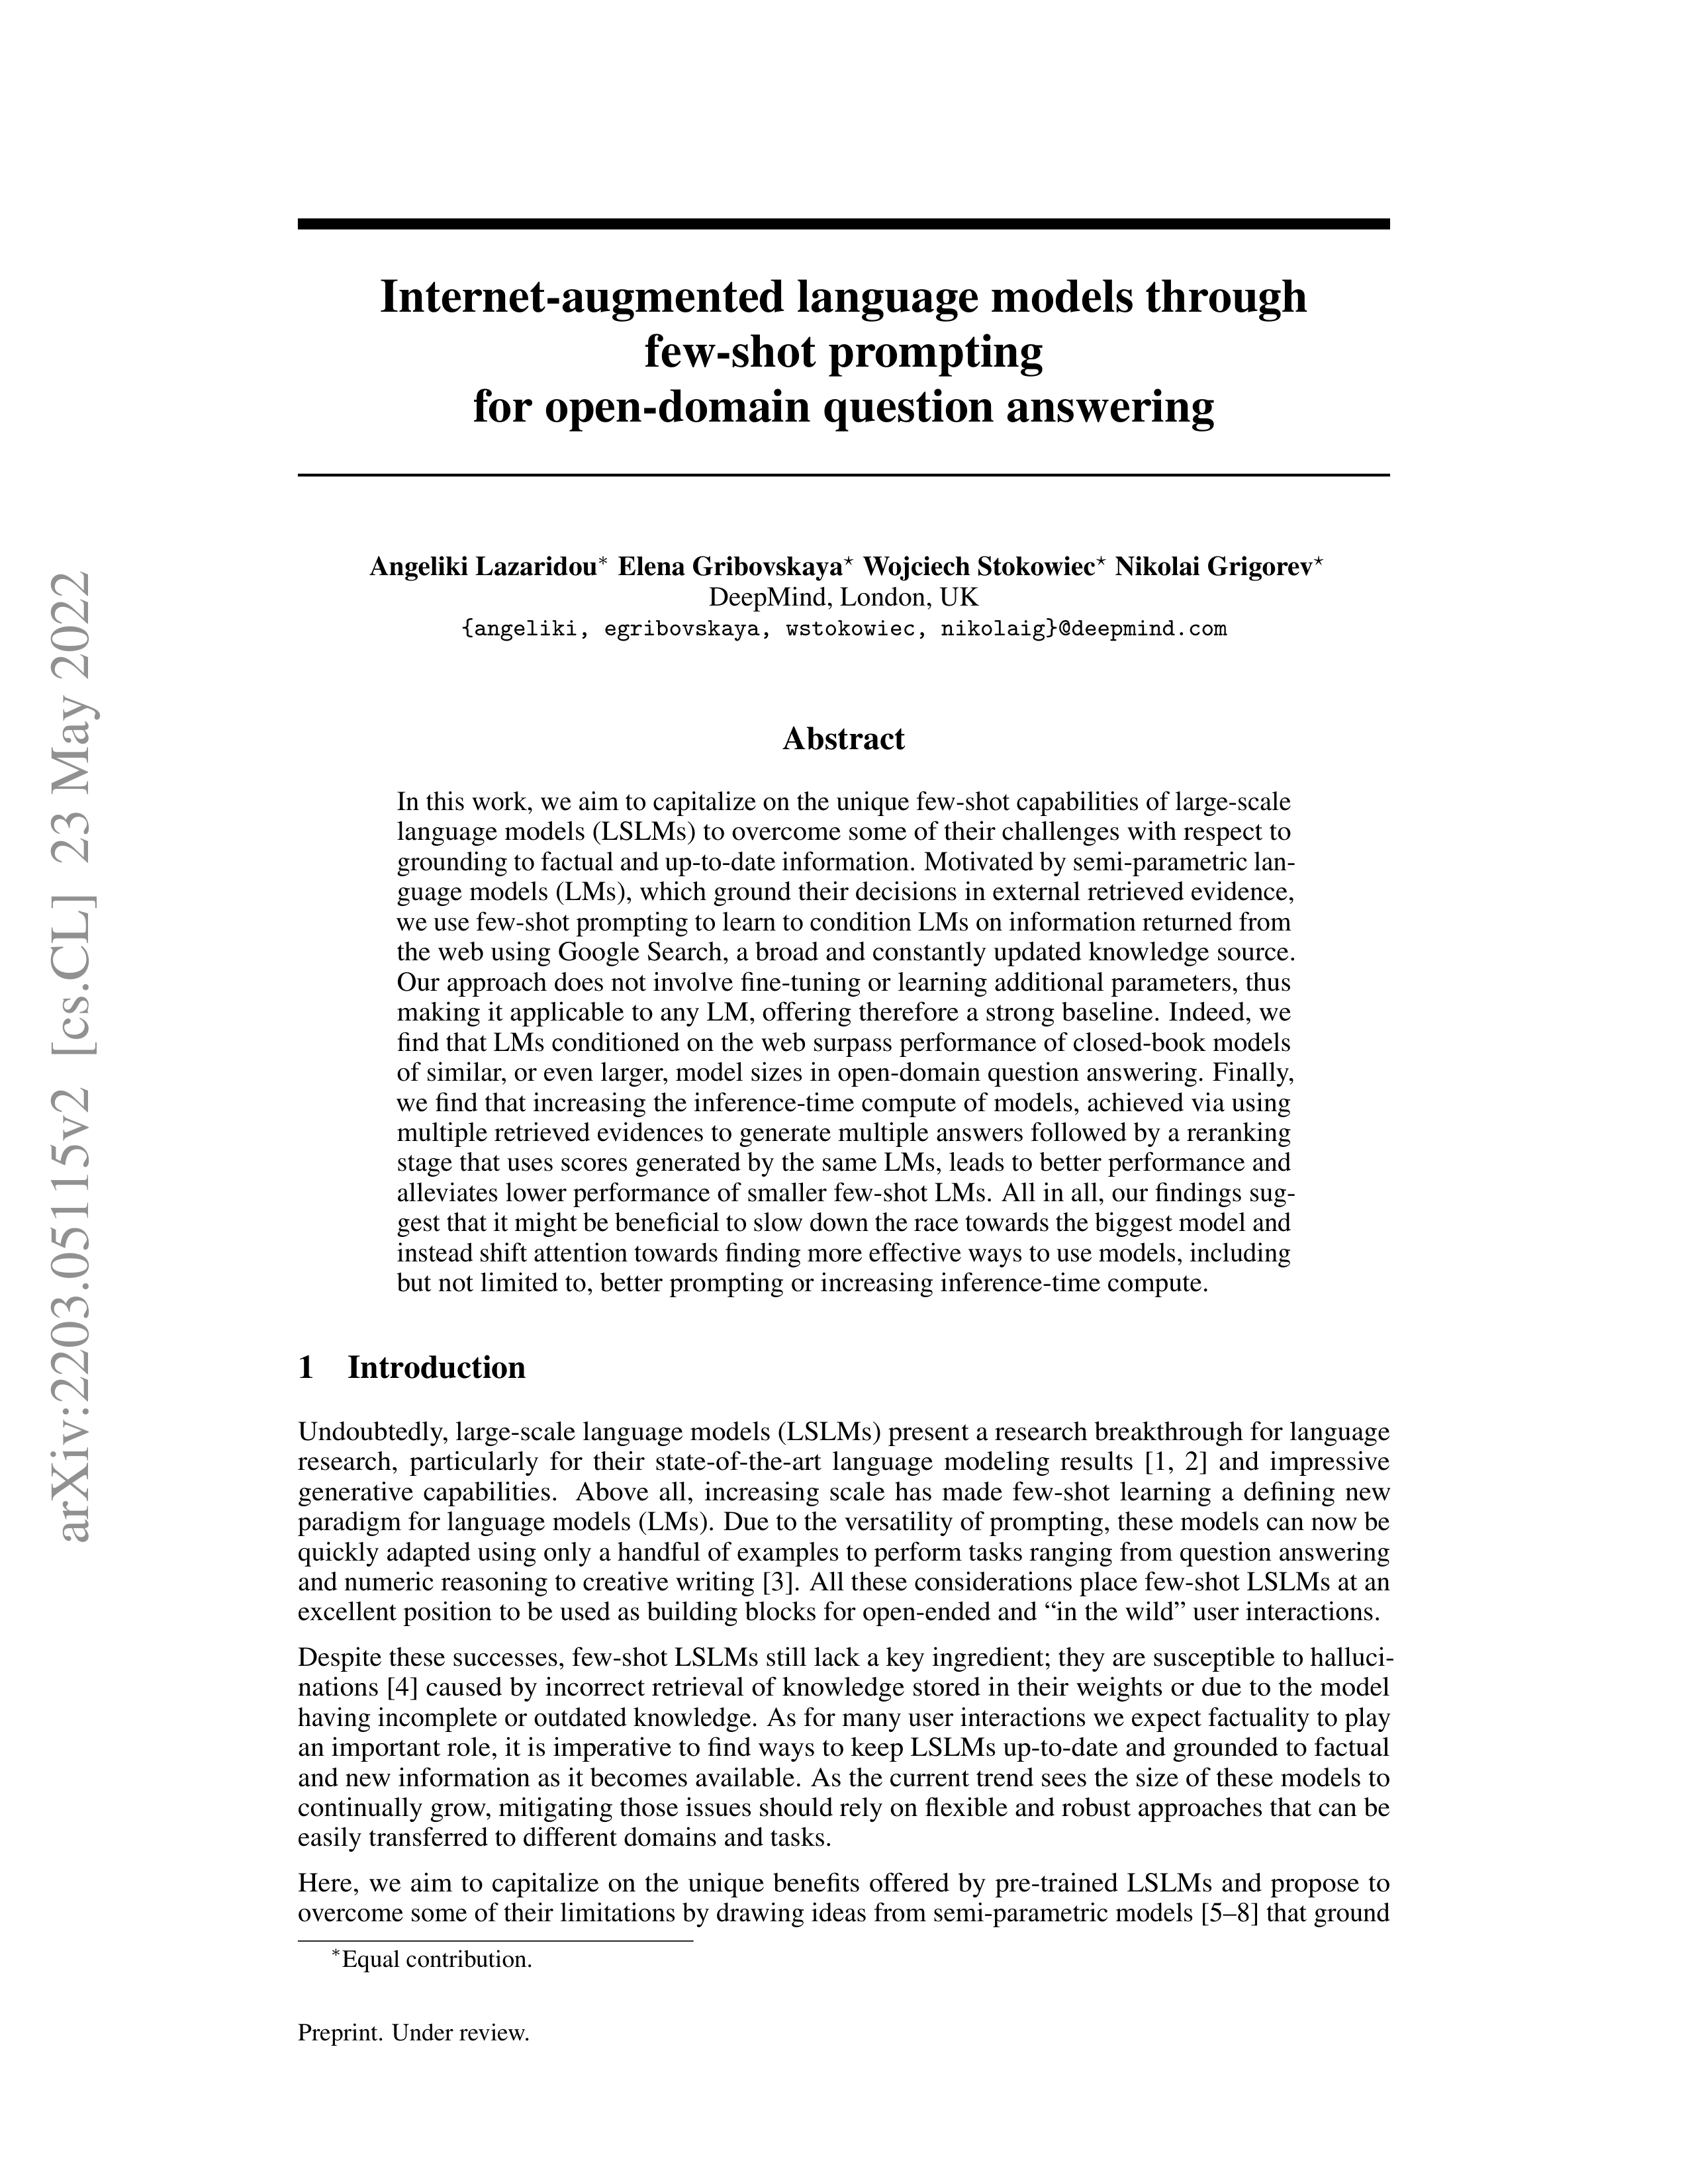

In [4]:
from IPython.display import display, Image
from base64 import b64decode
display(Image(data=b64decode(all_results[0]["base64_str"])))

In [5]:
import csv

# Save all_results to CSV
csv_filename = "irpapers-docs.csv"
with open(csv_filename, mode="w", newline='', encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=all_results[0].keys())
    writer.writeheader()
    for row in all_results:
        writer.writerow(row)
print(f"Saved all_results to {csv_filename}")


Saved all_results to irpapers-docs.csv


In [6]:
print(len(all_results))

3230


In [29]:
from datasets import load_dataset

test = load_dataset("weaviate/irpapers-docs")

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

IRPapers.csv:   0%|          | 0.00/311M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

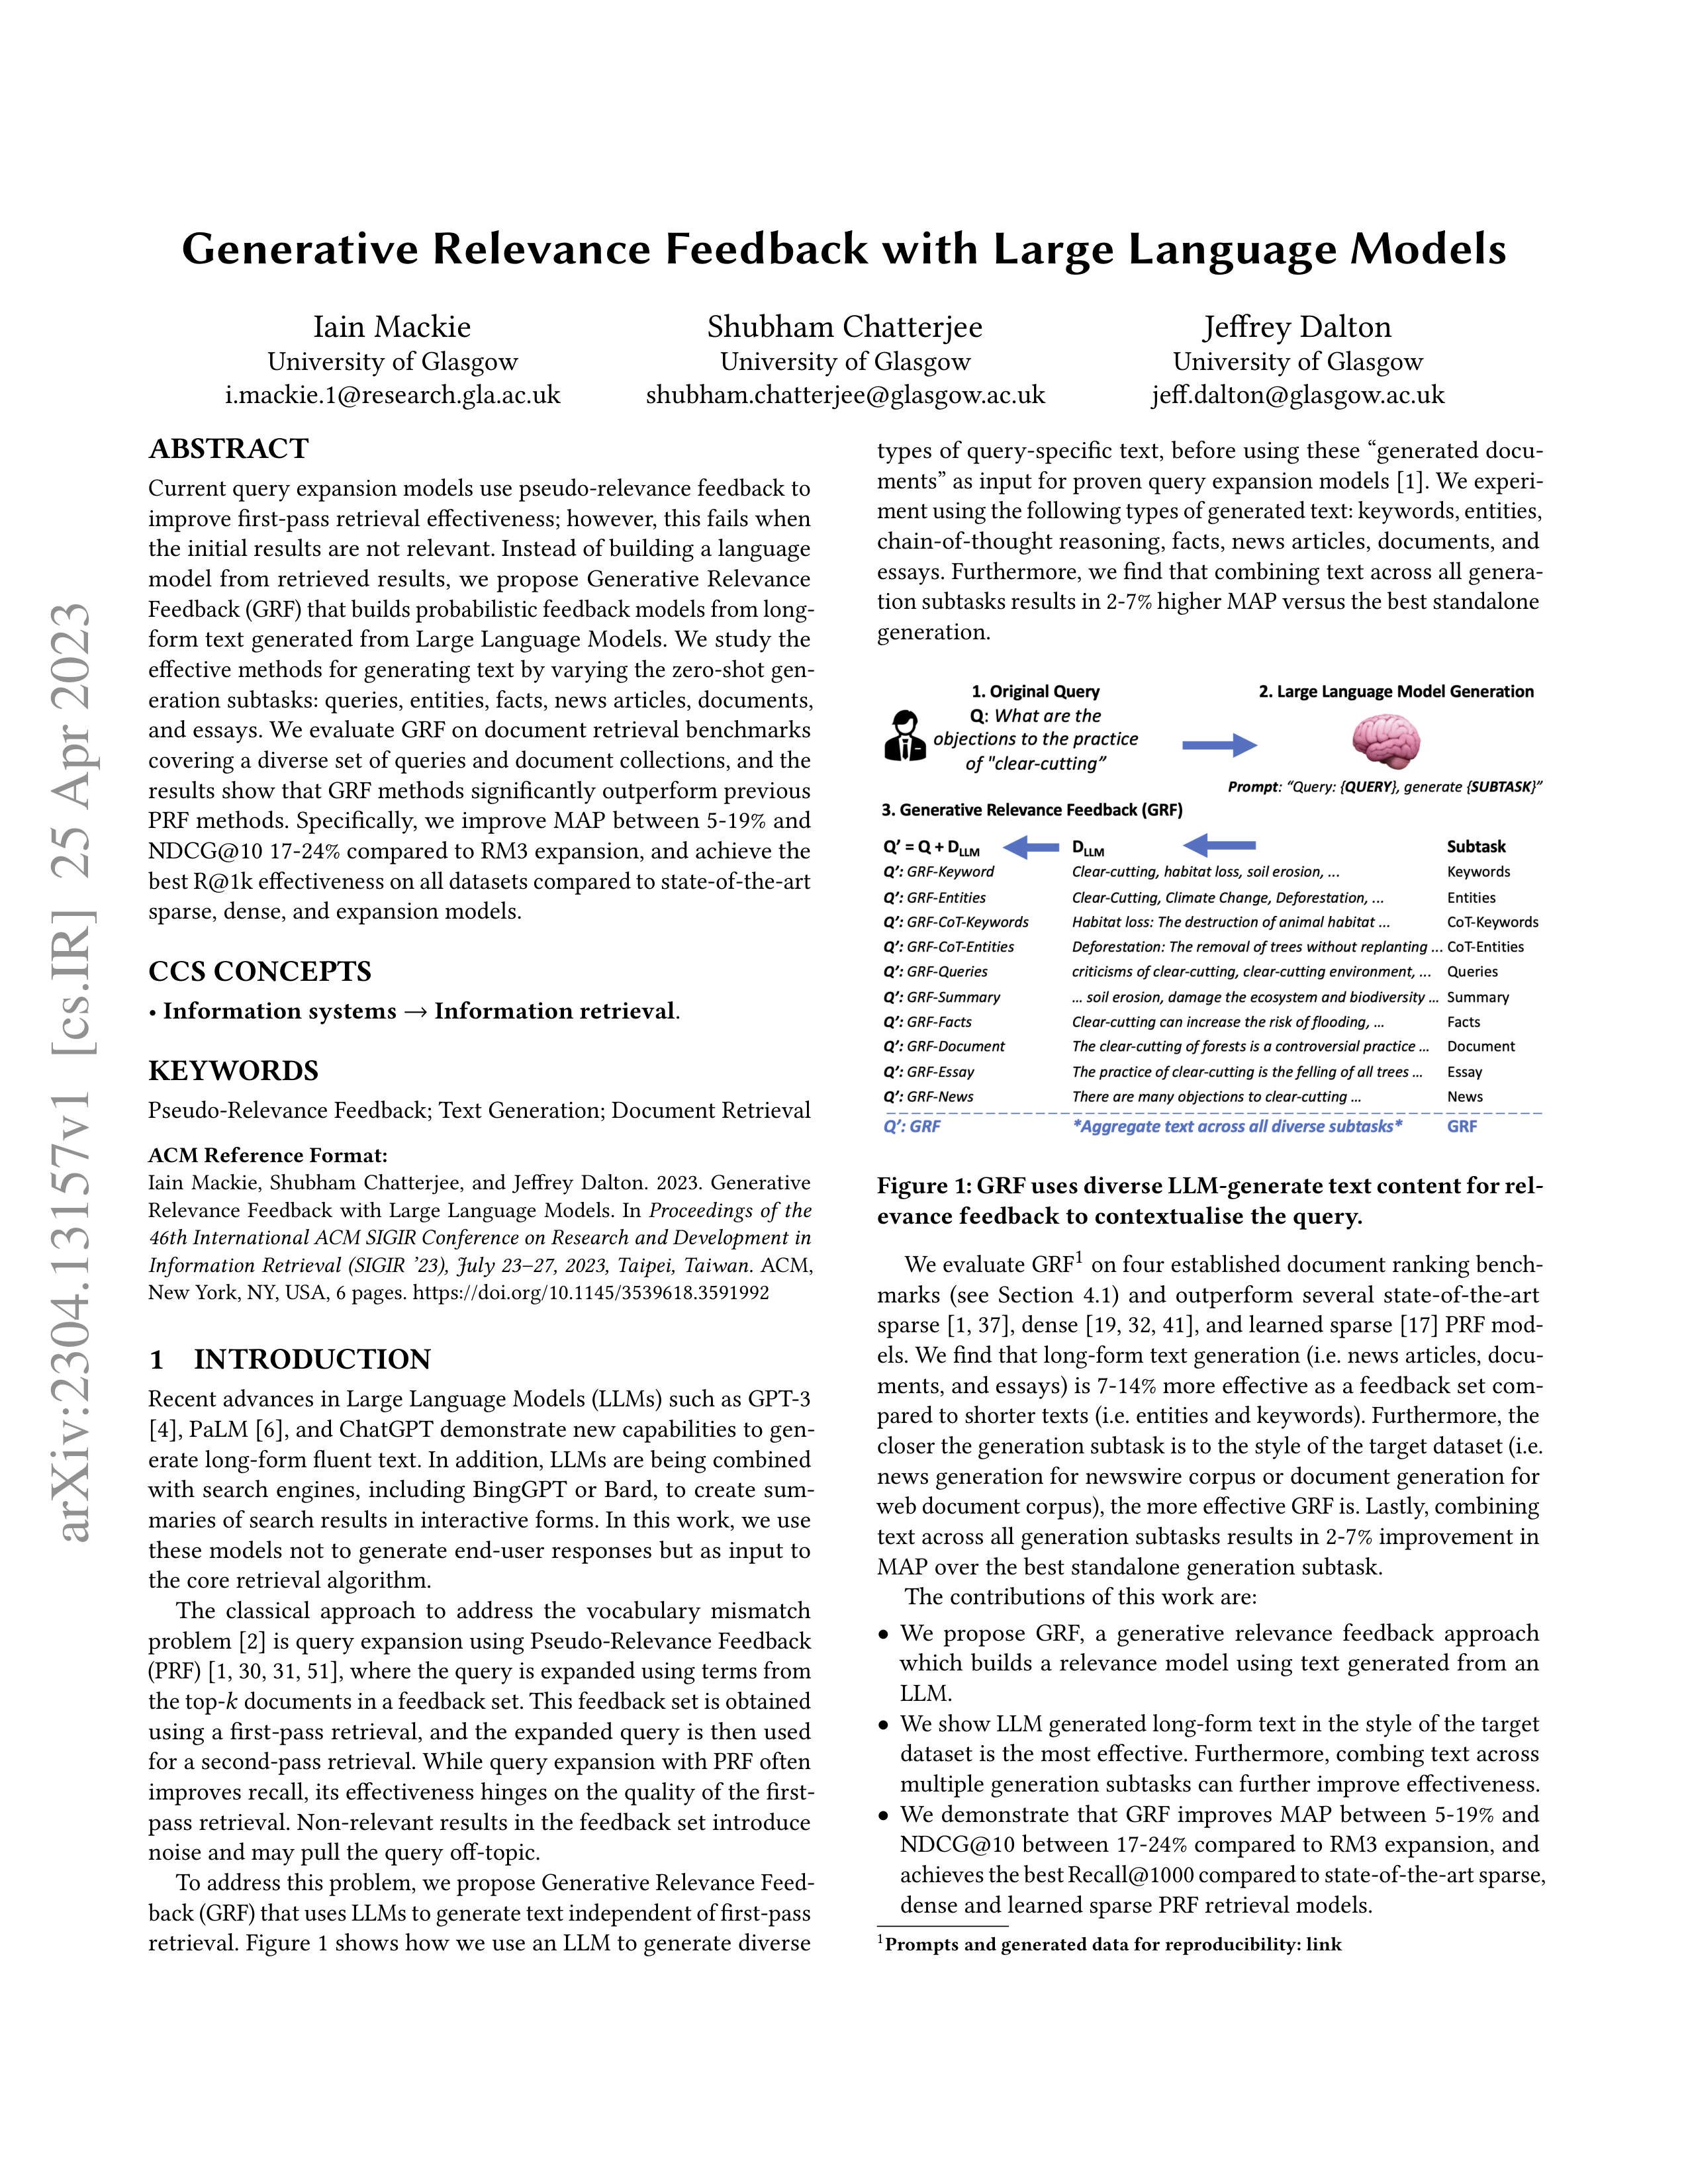

In [30]:
display(Image(data=b64decode(test["train"][0]["base64_str"])))